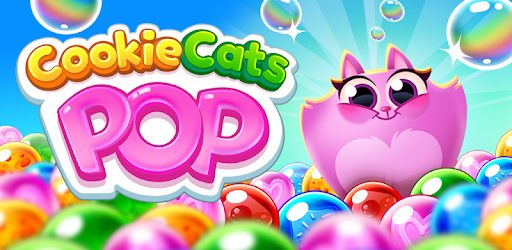

# Cookie Cat - Introduction
Cookie cats is a popular mobile puzzle game where players complete a task and level up. 
While players complete levels, they encounter gates after completing a certain number of levels. 
Gates force players to wait for sometime before they can play further.

This notebook performs A/B testing for the following hypothesis:
<br></br>
<b> If moving the first gate from level 30 to level 40 will increase retention rate. </b>

Experimental design:
- Group A will encounter the gate at level 30
- Group B will encounter the gate at level 40

## Packages and setup

In [1]:
import numpy as np
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt
import os

import scipy.stats as stats
from scipy.stats import shapiro
from scipy.stats import levene
from scipy.stats import ttest_ind

#parameter settings
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
import warnings
warnings.filterwarnings("ignore")
warnings.simplefilter(action='ignore', category=FutureWarning)

### Reading data and initial processing

In [2]:
#Read data using pandas
user_df=pd.read_csv("cookie_cats.csv")

#Check data types of each column using "dtypes" function
print("Data types for the data set:")
user_df.dtypes

#Check dimension of data i.e. # of rows and #column using pandas "shape" funtion
print("Shape of the data i.e. no. of rows and columns")
user_df.shape

#display first 5 rows of the data using "head" function
print("First 5 rows of the raw data:")
user_df.head(5)

Data types for the data set:


userid             int64
version           object
sum_gamerounds     int64
retention_1         bool
retention_7         bool
dtype: object

Shape of the data i.e. no. of rows and columns


(90189, 5)

First 5 rows of the raw data:


,userid,version,sum_gamerounds,retention_1,retention_7
0,116,gate_30,3,False,False
1,337,gate_30,38,True,False
2,377,gate_40,165,True,False
3,483,gate_40,1,False,False
4,488,gate_40,179,True,True


## Step1: Detect and resolve problems in the data (Missing value, Outliers, etc.)

### 1.1 Identify missing value

In [3]:
#Check for any missing values in the data using isnull() function
user_df.isnull().sum()

userid            0
version           0
sum_gamerounds    0
retention_1       0
retention_7       0
dtype: int64

In [5]:
# to check if there is any duplicate user_id present in the data
user_df.userid.nunique()/user_df.shape[0]

1.0

### 1.2 Identify outliers

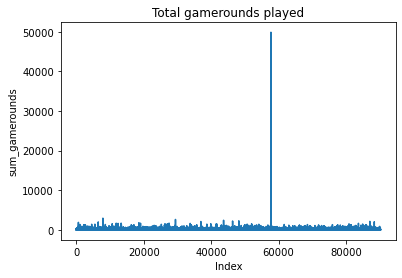

In [7]:
#Check for outlier values in sum_gamerounds column
_ = plt.title("Total gamerounds played")
_ = plt.xlabel("Index")
_ = plt.ylabel("sum_gamerounds")
_ = plt.plot(user_df.sum_gamerounds)

In [8]:
#Based on the plot, filter out the outlier from sum_gamerounds played; Use max() function to find the index of the outlier
user_df2 = user_df.drop(user_df['sum_gamerounds'].idxmax())


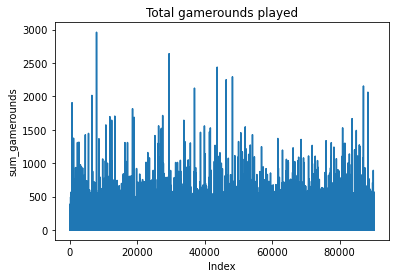

In [9]:
#Plot the graph for sum_gamerounds player after removing the outlier
_ = plt.title("Total gamerounds played")
_ = plt.xlabel("Index")
_ = plt.ylabel("sum_gamerounds")
_ = plt.plot(user_df2.sum_gamerounds)

## 2. Plot summary statistics and identify trends to answer basis business questions

### 2.1 What is the overall 7-day retention rate of the game?

In [10]:
#Insert calculation for 7-day retention rate

ret_rate_7_status = user_df2.retention_7.value_counts()
retention_rate_7 = ret_rate_7_status[1] / (ret_rate_7_status[0] + ret_rate_7_status[1]) * 100
print("Overall 7 days retention rate of the game for both versions is: " ,retention_rate_7,"%")


Overall 7 days retention rate of the game for both versions is:  18.60557945624695 %


### 2.2 How many players never played the game after installing? 

In [17]:
# Find number of customers with sum_gamerounds is equal to zero
n_cust_gamerounds_greater_zero = user_df2[user_df2.sum_gamerounds == 0].shape[0]
n_cust_gamerounds_greater_zero

3994

### 2.3 Does the number of users decrease as the level progresses highlighting the difficulty of the game?

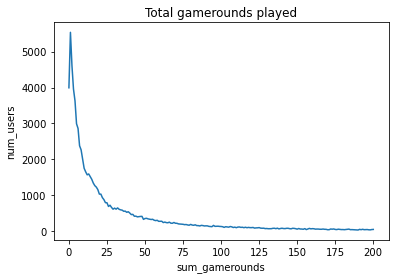

In [18]:
# Group by sum_gamerounds and count the number of users for the first 200 gamerounds
# Use plot() function on the summarized stats to visualize the chart

n_cust_gamerounds = user_df2[user_df.sum_gamerounds<=200].groupby('sum_gamerounds').size()

_ = plt.title("Total gamerounds played")
_ = plt.xlabel("sum_gamerounds")
_ = plt.ylabel("num_users")
_ = plt.plot(n_cust_gamerounds)

## 3. Generate crosstab for two groups of players to understand if there is a difference in 7 days retention rate & total number of game rounds played

### 3.1 Seven days retention rate summary for different game versions

In [19]:
#Create cross tab for game version and retention_7 flag counting number of users for each possible categories

pd.crosstab(user_df2.version, user_df2.retention_7).apply(lambda r: r/r.sum(), axis=1)

retention_7,False,True
version,,
gate_30,0.809817,0.190183
gate_40,0.818000,0.182000


### <font color = navy> Based on the above findings, there appears to be negligible difference between the 2 groups. 

### 3.2 Gamerounds summary for different game versions

In [20]:
#use pandas group by to calculate average game rounds played summarized by different versions

user_df2[["version","sum_gamerounds"]].groupby("version").agg("mean")

,sum_gamerounds
version,
gate_30,51.342111
gate_40,51.298776


### <font color = navy> Total number of gamerounds played in total by each player **does not differ** based on  different versions of the game

## 4. Perform two-sample test for groups A and B to test statistical significance amongst the groups in the sum of game rounds played i.e., if groups A and B are statistically different

### Initial data processing

In [22]:
#Define A/B groups for hypothesis testing
#user_df["version"] = np.where(user_df.version == "gate_30", "A", "B")
group_A=pd.DataFrame(user_df2[user_df2.version=="gate_30"]['sum_gamerounds'])
group_B=pd.DataFrame(user_df2[user_df2.version=="gate_40"]['sum_gamerounds'])

### 4.1 Shapiro test of Normality

 ###  <font color = 'salmon'> Brief introduction to Shapiro test </font>
The Shapiro-Wilk test examines if a variable is normally distributed in some population. 
- The null hypothesis is that the variable is normally distributed in some population i.e. variable values are a simple random sample from a normal distribution
- Reject the null hypothesis if p < 0.05 i.e. the variable is **NOT** normally distributed

In [13]:
#---------------------- Shapiro Test ----------------------
# NULL Hypothesis H0: Distribution is normal
# ALTERNATE Hypothesis H1: Distribution is not normal    

#test for group_A
stat_A, p_A = shapiro(group_A)

#test for group_B
stat_B, p_B = shapiro(group_B)

# normality test
print('Group A Statistics=%.3f, p=%.3f' % (stat_A, p_A))
print('Group B Statistics=%.3f, p=%.3f' % (stat_B, p_B))

# interpret
alpha = 0.05
if p_A > alpha:
    print('Group A Distribution is normal (fail to reject H0)')
else:
    print('Group A Distribution is not normal (reject H0)')
    
if p_B > alpha:
    print('Group B Distribution is normal (fail to reject H0)')
else:
    print('Group B Distribution is not normal (reject H0)')

Group A Statistics=0.088, p=0.000
Group B Statistics=0.483, p=0.000
Group A Distribution is not normal (reject H0)
Group B Distribution is not normal (reject H0)


### <font color = navy> Since both p values are below 0.05, we reject null hypothesis and conclude that the alternate hypothesis is true. 

### <font color = navy> i.e. in conclusion, the samples are NOT drawn from a normal distribution. 

### 4.2 Test of homegienity of variance

 ###  <font color = 'salmon'> Brief introduction to Levene's test </font>
 
Levene's test is used to test if k samples have equal variance. Equal variance across samples is called homogenity of variance. 

Note: Independent T-test or one way ANOVA would require homogenity assumption, hence we use Levene's test first to ensure homogenity, especially if samples sizes are different. 

<b> Levene's Test Assumptions:
- Independent Observations
- The test variable is quantitative i.e. not nominal or ordinal
</b>

Levene's Test:
- Null Hypothesis is that the group have equal population variances
- Reject the null hypothesis if p < 0.05 i.e. the group do not have equal population variances

In [25]:
#---------------------- Levene's Test ----------------------
# NULL Hypothesis H0: Two groups have equal variances
# ALTERNATE Hypothesis H1: Two groups do not have equal variances

# Perform levene's test and accept or reject the null hypothesis based on the results
statistic, p_value = levene(group_A['sum_gamerounds'], group_B['sum_gamerounds'])

print('Levene Test Finding, Statistic=%.3f, p=%.3f' % (statistic, p_value))

# Inference
alpha = 0.05
if p_value > alpha:
    print('Two groups have equal variances (fail to reject H0)')
else:
    print('Two groups do not have equal variances (reject H0)')

Levene Test Finding, Statistic=0.075, p=0.784
Two groups have equal variances (fail to reject H0)


### <font color = navy> p value is more than 0.05, hence we fail to reject alternative hypothesis. i.e. both groups have equal variances. 

### 4.3 Test of significance: Two sample test

 ###  <font color = 'salmon'> Brief introduction to T-tests </font>
 
Two Sample T-test or independent sample t-test is a method used to test whether the unknown population means of two groups are equal or not. This is also used in A/B tests. 

<b> Two-sample T Test Assumptions:
- Data must be independent 
- Data must be obtained via a random sample from the population
- Data in each group are normally distributed
- Data values are continuous
- The variance from the two independent groups are equal
</b>

FYI - If there are more than 2 groups, ANOVA is used. 

To carry out the test:
- Null Hypothesis is that 2 population means are equal. 
- Reject the null hypothesis if p < 0.05 i.e. the group do not have equal population means

### <font color = navy> Unfortunately, we cannot use t-test because the distribution is not normal. We will use Mann-Whitney U Test instead. 

 ###  <font color = 'salmon'> Brief introduction to Mann-Whitney U Test </font>
 
The Mann-Whitney U test is used to compare differences between two independent groups when the dependent variable is either ordinal or continuous, **but not normally distributed.**

Man-Whitney U Test Assumptions:
- Dependent variable should be measured at the ordinal or continuous level 
- Independent variables should consist of 2 categorical, independent groups i.e. male/female 
- There should be independence of observations i.e. there is no relationship between observations in each group or between the groups themselves
- Mann-Whitney U Test can be used when two variables are not normally distributed


Unlike the independent-samples t-test, the Mann-Whitney U test allows you to draw different conclusions about your data depending on the assumptions you make about your data's distribution. 

To carry out the test:
- The null hypothesis is the two samples are equal 
- The alternative hypothesis is that the two samples are different however, they could be different in many ways 
- Different in centre, spread, shape

 

In [31]:
#---------------------- Two samples test ----------------------
# NULL Hypothesis H0: Two samples are equal
# ALTERNATE Hypothesis H1: Two samples are different

#Apply relevant two sample test to accept or reject the NULL hypothesis
statistic, p_value = stats.mannwhitneyu(group_A.sum_gamerounds,group_B.sum_gamerounds)

print('Mann Whitney Test Finding, Statistic=%.3f, p=%.3f' % (statistic, p_value))

# Inference
alpha = 0.05
if p_value > alpha:
    print('Two groups have equal mean i.e. Two Samples are Equal (fail to reject H0)')
else:
    print('Two groups do not have equal mean i.e. Two Samples are Different (reject H0)')

Mann Whitney Test Finding, Statistic=1009027049.500, p=0.025
Two groups do not have equal mean i.e. Two Samples are Different (reject H0)


In [32]:
#---------------------- Two samples test ----------------------
# NULL Hypothesis H0: Two samples are equal
# ALTERNATE Hypothesis H1: The first sample is greater than the second sample

#Apply relevant two sample test to accept or reject the NULL hypothesis
statistic, p_value = stats.mannwhitneyu(group_A.sum_gamerounds,group_B.sum_gamerounds,alternative="greater")

print('Mann Whitney Test Finding, Statistic=%.3f, p=%.3f' % (statistic, p_value))

# Inference
alpha = 0.05
if p_value > alpha:
    print('Two groups have equal mean i.e. Two Samples are Equal (fail to reject H0)')
else:
    print('Two groups do not have equal mean i.e. The First Sample is Greater than the Second Sample (reject H0)')

Mann Whitney Test Finding, Statistic=1024285761.500, p=0.025
Two groups do not have equal mean i.e. The First Sample is Greater than the Second Sample (reject H0)


### <font color = navy>  Based on the above finding, it appears that Group A and Group B are statistically different 

## Q5. Based on significance testing results, if groups A and B are statistically different, which level has more advantage in terms of player retention and number of game rounds played

In [33]:
#Analyze the 1 day and 7 days retention rate for two different groups using group by function

user_df2[["version","retention_7","retention_1"]].groupby("version").agg("mean")


,retention_7,retention_1
version,,
gate_30,0.190183,0.448198
gate_40,0.182000,0.442283


### <font color = navy>  Based on the above finding, it appears that Gate 30 has higher retention rate

## Using bootstrap resampling to plot the retention rate distribution for both the groups in order to visualize effect of different version of the game on retention.

 ###  <font color = 'salmon'> Brief introduction to Bootstrap Sampling </font>
 
Bootstrap method is a resampling technique used to estimate statistics on a population by sampling a dataset with replacement. 
It can be used to estimate summary statistics such as the mean or standard deviation. 

To carry out bootstrap sampling:
1) Choose a number of bootstrap samples to perform <br></br>
2) Choose a sample size <br></br>
3) For each bootstrap sample: <br></br>
- Draw a sample with replacement with the chosen size
- Calculate the statistic on the sample 

4) Calculate the mean of the calculated sample statistics 

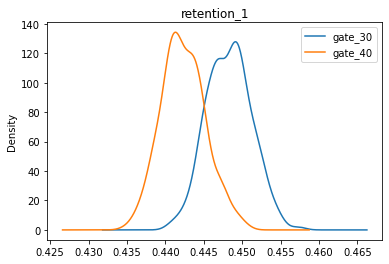

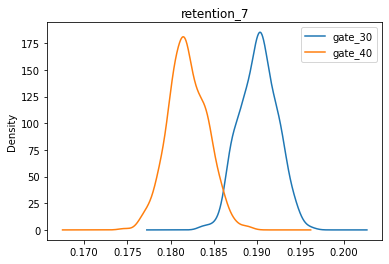

In [61]:
list_1day  = pd.DataFrame(columns=['gate_30', 'gate_40'])
list_7day = pd.DataFrame(columns=['gate_30', 'gate_40'])

for i in range(500):
    boot_mean1 = user_df2.sample(frac=0.7, replace=True).groupby('version')['retention_1', 'retention_7'].mean()
    boot_mean1_T = boot_mean1.T
    list_1day = list_1day.append(boot_mean1_T.iloc[0], ignore_index = True)
    list_7day = list_7day.append(boot_mean1_T.iloc[1], ignore_index = True)

    
_ = list_1day.plot(kind="kde", title="retention_1")
plt.show()
    
_ = list_7day.plot(kind="kde",title="retention_7")
plt.show()    

### <font color = navy>  Similar to our earlier findings, we would recommend to go with Gate 30 as it provides better user retention rate 